<a href="https://colab.research.google.com/github/abdallaho98/AutoSpeech/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
!pip3 install ktrain

In [162]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [163]:
import ktrain
from ktrain import text

In [ ]:
import pandas as pd
filepath = 'legalts.txt'
df = pd.DataFrame(columns=('type', 'content'))
with open(filepath) as fp:
   line = fp.readline()
   cnt = 0
   while line:
       x = line.strip().split("  ")
       df.loc[cnt] = [int(x[1]) , x[0]]
       line = fp.readline()
       cnt += 1
df['type'] = df['type'].apply(lambda x: 'right' if x == 1 else 'permit' if x == 2 else 'obligation' if x == 3 else 'prohibition' if x == 4 else 'other')
df.columns = ['label', 'text']
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
df = df[['text', 'right', 'permit','obligation' ,'prohibition' , 'other']]
df.head()

,text,right,permit,obligation,prohibition,other
0,ليس للشركاء في مال شائع أن يطلبوا قسمته إذا تب...,0,0,0,1,0
1,إذا وقع تحريف في نص السفتجة فالأشخاص الموقعون ...,0,0,0,0,1
2,يجوز الحجز على الأجر أو المرتب بقيمة النفقة ال...,0,1,0,0,0
3,يعين القاضي طبقا لأحكام قانون الأسرة، مقدما من...,0,0,1,0,0
4,يجوز للعموم المعارضة في أي تصحيح قضائي أو إدار...,0,1,0,0,0


In [196]:
import pandas as pd
import snowballstemmer
import re
import string
ar_light_stem = snowballstemmer.stemmer('arabic') 
filepath = 'legalts.txt'
df = pd.DataFrame(columns=('type', 'content'))
with open(filepath) as fp:
   line = fp.readline()
   cnt = 0
   while line:
       x = line.strip().split("  ")
       result = re.sub(r'[0-9,.()،]+', '', x[0])
       listStrin = [ar_light_stem.stemWord(text) for text in result.split(' ')]
       strin = ' '.join(listStrin)
       df.loc[cnt] = [int(x[1]) , strin]
       line = fp.readline()
       cnt += 1
df['type'] = df['type'].apply(lambda x: 'right' if x == 1 else 'permit' if x == 2 else 'obligation' if x == 3 else 'prohibition' if x == 4 else 'other')
df.columns = ['label', 'text']
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
df = df[['text', 'right', 'permit','obligation' ,'prohibition' , 'other']]
df.head()

,text,right,permit,obligation,prohibition,other
0,ليس شركاء في مال شايع ان يطلب قسم اذا تبين من ...,0,0,0,1,0
1,اذا وقع تحريف في نص سفتج فالاشخاص موقع علي بعد...,0,0,0,0,1
2,يجوز حجز علي اجر او مرتب قيم نفق غذاء اذا كان ...,0,1,0,0,0
3,يعين قاض طبق لاحكام قانون اسر مقدم من بين اقار...,0,0,1,0,0
4,يجوز عموم معارض في اي تصحيح قضاء او ادار لعقد ...,0,1,0,0,0


In [276]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
                                                                   'text', # name of column containing review text
                                                                   label_columns=['right', 'permit','obligation' ,'prohibition' , 'other'],
                                                                   maxlen=1000, 
                                                                   max_features=100000,
                                                                   preprocess_mode='standard',
                                                                   val_pct=0.2,
                                                                   ngram_range=6)


language: ar
Word Counts: 3232
Nrows: 828
828 train sequences
train sequence lengths:
	mean : 27
	95percentile : 48
	99percentile : 62
Adding 6-gram features
max_features changed to 185962 with addition of ngrams
Average train sequence length with ngrams: 144
train (w/ngrams) sequence lengths:
	mean : 145
	95percentile : 273
	99percentile : 355
x_train shape: (828,1000)
y_train shape: (828, 5)
Is Multi-Label? False
207 test sequences
test sequence lengths:
	mean : 25
	95percentile : 44
	99percentile : 52
Average test sequence length with ngrams: 47
test (w/ngrams) sequence lengths:
	mean : 48
	95percentile : 107
	99percentile : 181
x_test shape: (207,1000)
y_test shape: (207, 5)


In [277]:
model = text.text_classifier('nbsvm', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=6)

Is Multi-Label? False
compiling word ID features...
maxlen is 1000
building document-term matrix... this may take a few moments...
rows: 1-828
computing log-count ratios...
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
138/138 [==============================] - 1s 4ms/step - loss: 1.6068 - accuracy: 0.3527
Epoch 2/1024
138/138 [==============================] - 1s 4ms/step - loss: 1.6062 - accuracy: 0.3587
Epoch 3/1024
138/138 [==============================] - 1s 4ms/step - loss: 1.6037 - accuracy: 0.3816
Epoch 4/1024
138/138 [==============================] - 0s 4ms/step - loss: 1.5938 - accuracy: 0.4807
Epoch 5/1024
138/138 [==============================] - 1s 4ms/step - loss: 1.5546 - accuracy: 0.7633
Epoch 6/1024
138/138 [==============================] - 1s 4ms/step - loss: 1.4129 - accuracy: 0.9505
Epoch 7/1024
138/138 [==============================] - 1s 4ms/step - loss: 1.0198 - accuracy: 0.9807
Epoch 8/1024
138/138 [==============================] - 0s 4ms/step - loss: 0.4627 - accuracy: 0.9891
Epoch 9/1024
138/138 [==============================] - 1s 4ms/step - loss: 0.1509 - accuracy: 0.9940

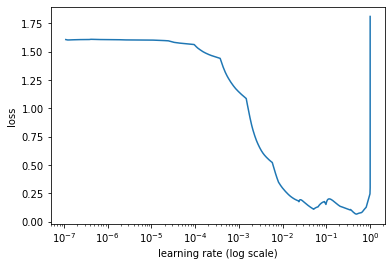

In [278]:
learner.lr_find(show_plot=True)

In [286]:
learner.autofit(1e-3, 1)



begin training using triangular learning rate policy with max lr of 0.001...
138/138 [==============================] - 1s 4ms/step - loss: 0.1897 - accuracy: 0.9952 - val_loss: 0.8905 - val_accuracy: 0.7391


In [ ]:
learner.view_top_losses(n=3, preproc=preproc)

----------
id:1 | loss:1.47 | true:prohibition | pred:obligation)

يمنع علي محجوز لدي وفاء من مبالغ محجوز للمد محجوز علي من تاريخ توقيع حجز


In [ ]:
p = ktrain.get_predictor(learner.model, preproc)

In [ ]:
p.predict("لا يجوز أن يكون تأويل العبارات الغامضة في عقود الاذعان ضارا بمصلحة الطرف المذعن")

'prohibition'

In [ ]:
p.predict("يمنع إبطال العقد إذا لم يتمسك به صاحبه خلال خمس )5( سنوات.")

'prohibition'

In [ ]:
p.predict("يجوز أن يؤمر بالنفاذ المعجل بالنسبة لهذا الإجرا")

'permit'

In [ ]:
p.predict("يجوز تخفيض العقوبة المنصوص عليها قانونا بالنسبة للشخص الطبيعي الذي قضي بإدانته وتقررت إفادته بظروف مخففة")

'permit'

In [ ]:
p.save('/content/predictor')

In [ ]:
predictor = ktrain.load_predictor('/content/predictor')

In [ ]:
predictor.predict("يمنع إبطال العقد إذا لم يتمسك به صاحبه خلال خمس )5( سنوات.")

'prohibition'

In [ ]:
!zip -r /content/file.zip /content/predictor

  adding: content/predictor/ (stored 0%)
  adding: content/predictor/tf_model.h5 (deflated 81%)
  adding: content/predictor/tf_model.preproc (deflated 44%)
